<h1>Step 3 - Training SSD for Products Detection</h1>
Retail Product Recognition on Grocery Shelves  approach based on object detection framework (cascade object
detection with AdaBoost learning algorithm) and Histogram of Oriented Gradients (HOG). And it works with the following accuracy:

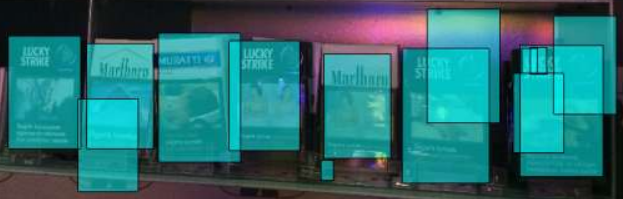

In [1]:
from IPython.display import Image as IPythonImage
IPythonImage('docs/images/packs_detection_accuracy.png', width=600)

proposed some improvements through constraints for eliminating false positives. And improved result looks following way:

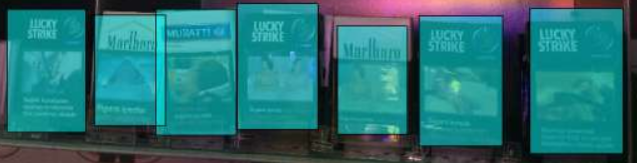

In [2]:
IPythonImage('docs/images/packs_detection_accuracy_improved.png', width=600)


For packs detection we will use SSD Mobilenet V1 model pre-trained on the COCO dataset. Training a model from the beginning could take even days, so we use knowledge transfer technique training ready model on new types of objects.

<h2>Data Preparation</h2>
Tensorflow Object Detection trainer can augment data, randomly crop parts of images etc. Unfortunatelly, on my home PC with small RAM with no SSD it works very slow with original high resolution images. So, what I'm going to do is to crop 5 random squares from each image and resize crops to 600x600 pictures. For the sake of clarity go to the data directory and create "detector" directory with "train", "eval" directories inside. We will put our square resized crops there.

In [4]:
import cv2
import pandas as pd
import numpy as np
import os
import io
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

/home/andrey/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
# current images path 
img_path = 'data/images/ShelfImages/'
# cropped parts destination
cropped_path = 'data/images/detector/'
# Step 1 results path
data_path = 'data/'
# output destination
detector_data_path = 'pack_detector/data/'

In [6]:
# read rects and photos dataframes
photos = pd.read_pickle(f'{data_path}photos.pkl')
products = pd.read_pickle(f'{data_path}products.pkl')

In [7]:
N_CROP_TRIALS = 6
CROP_SIZE = 1000

In [8]:
# returns random value in [s, f]
def rand_between(s, f):
    if s == f:
        return s
    return np.random.randint(s, f)

In [9]:
train_products, eval_products = [], []
for img_file, is_train in photos[['file', 'is_train']].values:
    img = cv2.imread(f'{img_path}{img_file}')
    img_h, img_w, img_c = img.shape
    for n in range(N_CROP_TRIALS):
        # randomly crop square
        c_size = rand_between(300, max(img_h, img_w))
        x0 = rand_between(0, max(0, img_w - c_size))
        y0 = rand_between(0, max(0, img_h - c_size))
        x1 = min(img_w, x0 + c_size)
        y1 = min(img_h, y0 + c_size)
        # products totally inside crop rectangle
        crop_products = products[(products.file == img_file) & 
                                 (products.xmin > x0) & (products.xmax < x1) &
                                 (products.ymin > y0) & (products.ymax < y1)]
        # no products inside crop rectangle? cropping trial failed...
        if len(crop_products) == 0:
            continue
        # name the crop
        crop_img_file = f'{img_file[:-4]}{x0}_{y0}_{x1}_{y1}.JPG'
        # crop and reshape to CROP_SIZExCROP_SIZE or smaller 
        # keeping aspect ratio
        crop = img[y0:y1, x0:x1]
        h, w, c = crop.shape
        ratio = min(CROP_SIZE/h, CROP_SIZE/w)
        crop = cv2.resize(crop, (0,0), fx=ratio, fy=ratio)
        crop = crop[0:CROP_SIZE, 0:CROP_SIZE]
        h, w, c = crop.shape
        # add crop inner products to train_products or eval_products list
        for xmin, ymin, xmax, ymax in \
                crop_products[['xmin', 'ymin', 'xmax', 'ymax']].values:
            xmin -= x0
            xmax -= x0
            ymin -= y0
            ymax -= y0

            xmin, xmax, ymin, ymax = [int(np.round(e * ratio)) 
                                      for e in [xmin, xmax, ymin, ymax]]
            product = {'filename': crop_img_file, 'class':'pack', 
                       'width':w, 'height':h,
                       'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax}
            if is_train:
                train_products.append(product)
            else:
                eval_products.append(product)
        # save crop top eval or train folder
        subpath = ['eval/', 'train/'][is_train]
        cv2.imwrite(f'{cropped_path}{subpath}{crop_img_file}', crop)

In [10]:
train_df = pd.DataFrame(train_products).set_index('filename')
eval_df = pd.DataFrame(eval_products).set_index('filename')

In [11]:
# at this point we have two folders with images and
# two dataframes with information about packs
train_df.head()

,class,height,width,xmax,xmin,ymax,ymin
filename,,,,,,,
C3_P06_N3_S3_1111_0_2993_2301.JPG,pack,798,1000,826,753,514,354
C3_P06_N3_S3_1111_0_2993_2301.JPG,pack,798,1000,925,840,265,104
C3_P06_N3_S3_1111_0_2993_2301.JPG,pack,798,1000,719,625,272,115
C3_P06_N3_S3_1111_0_2993_2301.JPG,pack,798,1000,800,714,747,612
C3_P06_N3_S3_1111_0_2993_2301.JPG,pack,798,1000,426,328,273,117


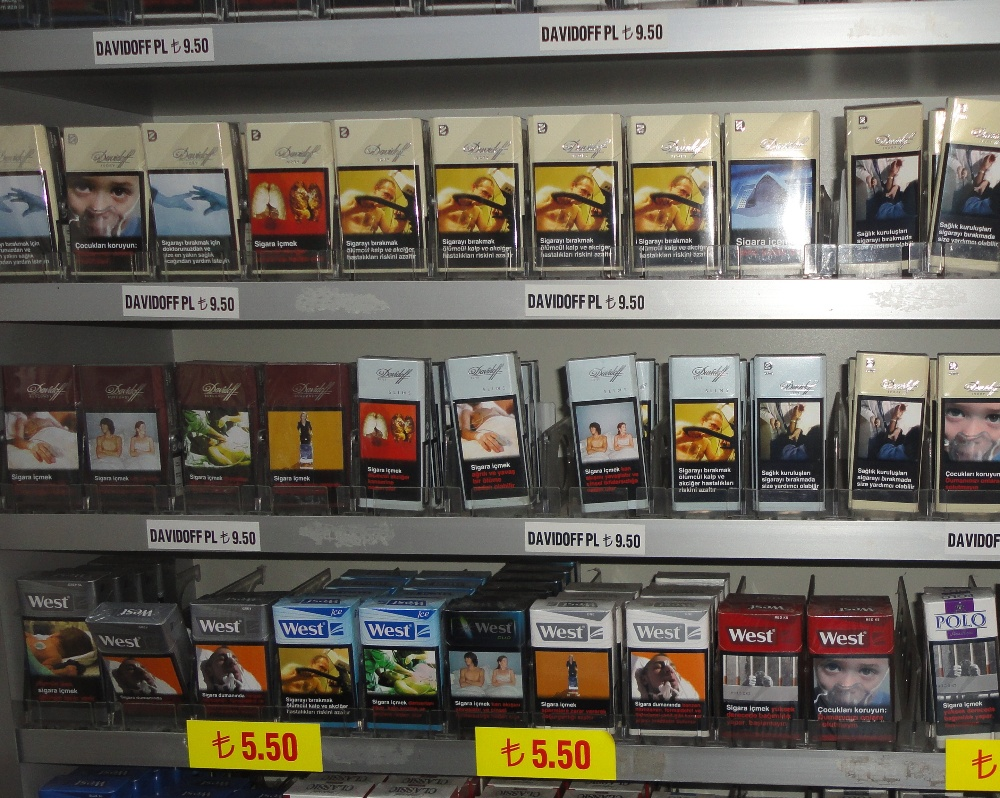

In [12]:
# example of training image
IPythonImage(f'{cropped_path}train/{train_df.index.values[0]}', width=600)

<h2>Preparing Tensorflow Records</h2>
So far we have 2 folders with cropped square images (one for training and one for evaluation). We also have 2 dataframes with information about packs places on each image. Now we need to convert everything to train.record and eval.record files that could be consumed by Tensorflow Object Detection trainer.

In [13]:
def class_text_to_int(row_label):
    if row_label == 'pack':
        return 1
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) 
            for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [14]:
def convert_to_tf_records(images_path, examples, dst_file):
    writer = tf.python_io.TFRecordWriter(dst_file)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, images_path)
        writer.write(tf_example.SerializeToString())
    writer.close()

In [15]:
convert_to_tf_records(f'{cropped_path}train/', train_df, f'{detector_data_path}train.record')
convert_to_tf_records(f'{cropped_path}eval/', eval_df, f'{detector_data_path}eval.record')

<h2>Running Training Proccess</h2>
go to pack_detector/models/ssd_mobilenet_v1 and create two subfolders: eval and train. Now I have the pack_detector folder with the following content:
<ul>
    <li>+data<ul><li>train.record</li><li>eval.record</li><li>pack.pbtxt</li></ul></li>
    <li>+models<ul><li>+ssd_mobilenet_v1<ul><li>+train</li><li>+eval</li><li>ssd_mobilenet_v1_pack.config</li></ul></li>
</ul>
Quick Start: Training a pet detector<br/>
        
Do the following steps to run the process:
<ul>
    <li>Install Tensorflow Object Detection API </li>
    <li>Go to the models/research/object_detection directory</li>
    <li>
        Copy your pack_detector folder to models/research/object_detection
    </li>
    <li>Run train process on GPU with:<br>
        python3 train.py --logtostderr \<br>
                         --train_dir=pack_detector/models/ssd_mobilenet_v1/train/ \<br>
                         --pipeline_config_path=pack_detector/models/ssd_mobilenet_v1/ssd_mobilenet_v1_pack.config
    </li>
    <li>Run eval proccess on CPU with:<br>
        CUDA_VISIBLE_DEVICES="" python3 eval.py \<br>
            --logtostderr \<br>
            --checkpoint_dir=pack_detector/models/ssd_mobilenet_v1/train \<br>
            --pipeline_config_path=pack_detector/models/ssd_mobilenet_v1/ssd_mobilenet_v1_pack.config \<br>
            --eval_dir=pack_detector/models/ssd_mobilenet_v1/eval
    </li>
    <li>Run tensorboard process with:<br>
        tensorboard --logdir=pack_detector/models/ssd_mobilenet_v1
    </li>
</ul>

<h2>Babysitting Training Proccess</h2>
The last our process is tensorboard. With it I can graphically see how your training proccess is going on. 

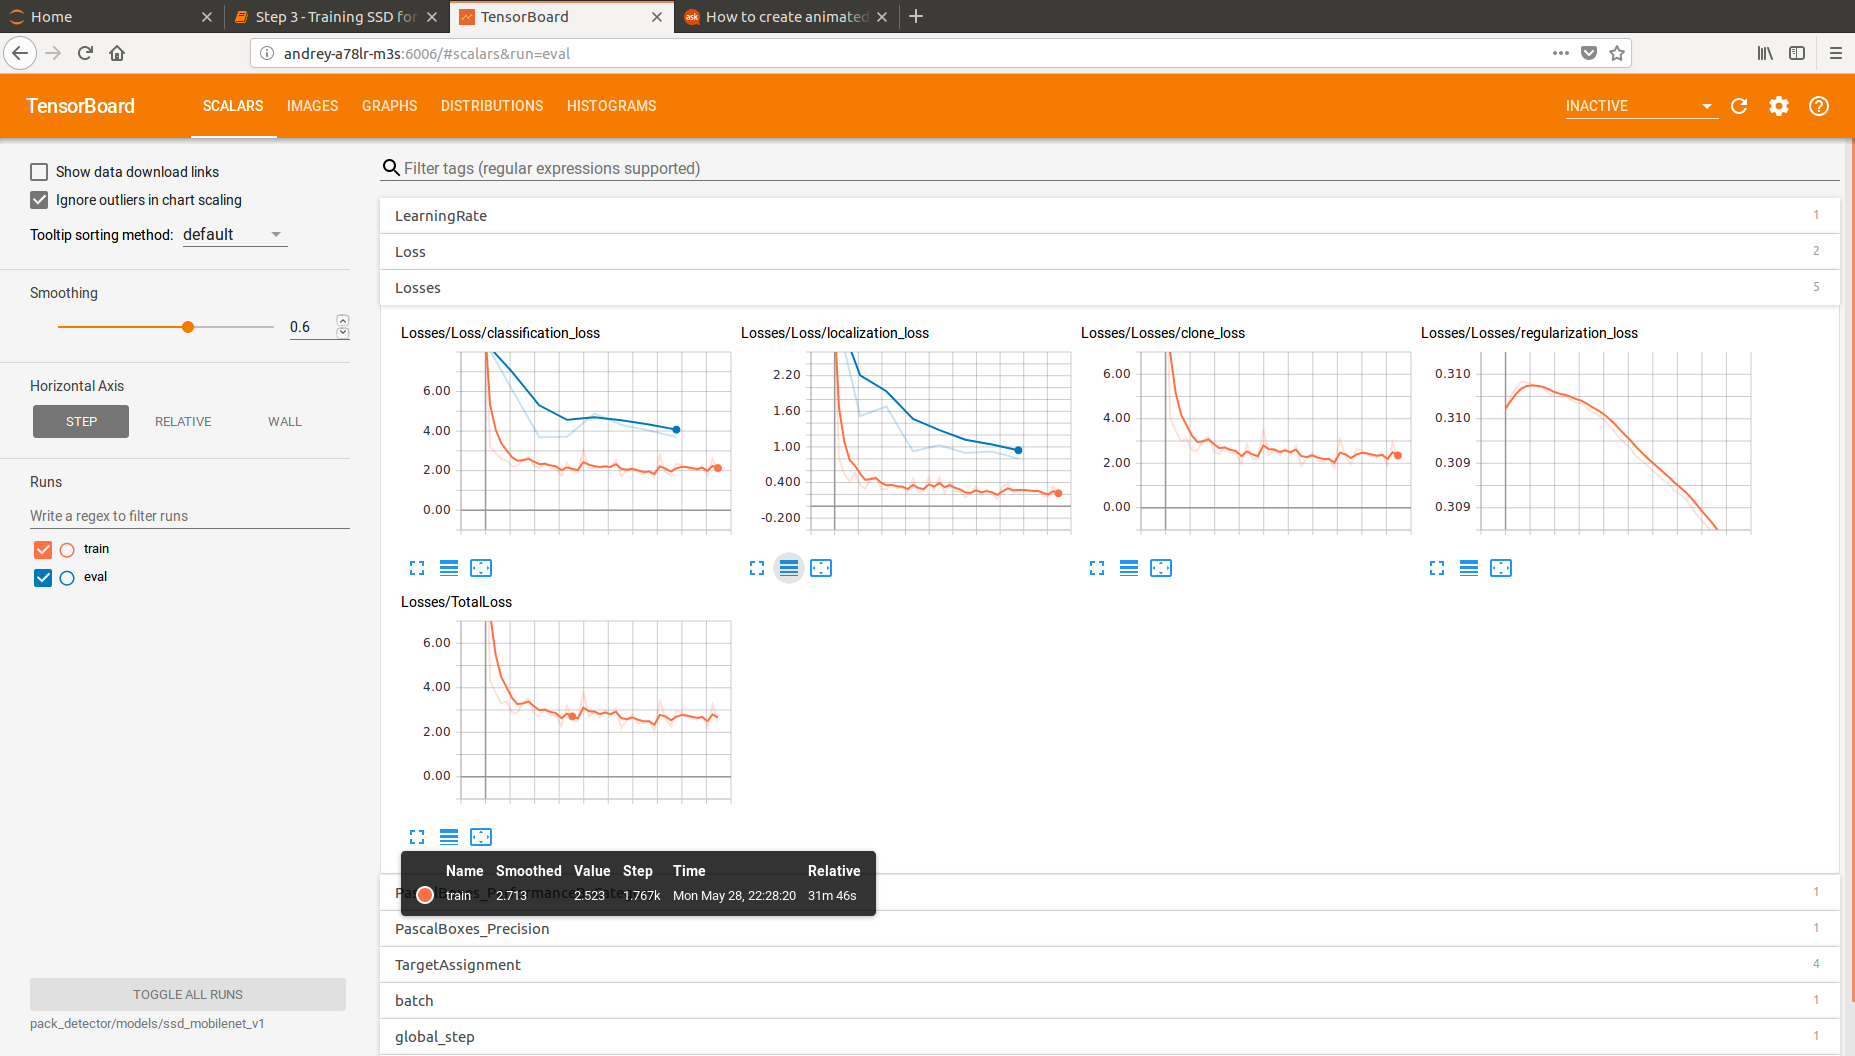

In [20]:
IPythonImage('docs/images/tensorboard.png', width=2200)

Now it's time to chose the best checkpoint and import it as a frozen graph. I will use this frozen graph for inference. Use the following command line,checkpoint number (I chose 13756):<br>
python3 export_inference_graph.py \ <br>
--input_type image_tensor \  <br>
--pipeline_config_path pack_detector/models/ssd_mobilenet_v1/ssd_mobilenet_v1_pack.config \ <br>
--trained_checkpoint_prefix pack_detector/models/ssd_mobilenet_v1/train/model.ckpt-13756 \ <br>
